### Preprocessing

In [1]:
# import relevant statistical packages
import numpy as np
import pandas as pd

In [2]:
# import data visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 8.a. Generating normally distribution predictor X and noise vector $\epsilon$

In [7]:
X = np.random.normal(size=100)
epsilon = np.random.normal(size=100)

In [8]:
len(X), len(epsilon)

(100, 100)

### 8.b. Generating response vector $Y$ = $\beta_0$ + $\beta_1$$X$ + $\beta_2$$X^2$ + $\beta_3$$X^3$ + $\epsilon$

In [13]:
BETA0 = 87.15
BETA1 = -2.85
BETA2 = 37.23
BETA3 = 56.0
Y = BETA0 + (BETA1*X) + (BETA2*pow(X, 2)) + (BETA3*pow(X, 3)) + epsilon

In [18]:
df = pd.DataFrame([X, Y]).T
df.columns = ['X', 'Y']
df.head()

,X,Y
0,-0.316910,90.852544
1,0.082986,86.312598
2,0.828883,142.802139
3,-1.506827,-15.784533
4,0.942414,165.214284


### 8.c. Best subset selection

In [351]:
# import custom packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_linear_regression as PLS
from sklearn.metrics import mean_squared_error

In [30]:
dfX = pd.DataFrame([X, pow(X, 2), pow(X, 3), pow(X, 4), pow(X, 5), pow(X, 6), pow(X, 7), pow(X, 8), pow(X, 9), pow(X, 10)]).T
dfX.columns = ['X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
dfX.head()

,X,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
0,-0.316910,0.100432,-0.031828,0.010087,-0.003197,1.013011e-03,-3.210331e-04,1.017385e-04,-3.224194e-05,1.021779e-05
1,0.082986,0.006887,0.000571,0.000047,0.000004,3.266115e-07,2.710420e-08,2.249272e-09,1.866582e-10,1.549003e-11
2,0.828883,0.687048,0.569482,0.472034,0.391261,3.243101e-01,2.688152e-01,2.228164e-01,1.846888e-01,1.530855e-01
3,-1.506827,2.270527,-3.421291,5.155293,-7.768135,1.170523e+01,-1.763776e+01,2.657705e+01,-4.004701e+01,6.034391e+01
4,0.942414,0.888144,0.836999,0.788800,0.743376,7.005674e-01,6.602244e-01,6.222047e-01,5.863743e-01,5.526072e-01


In [36]:
dfY = pd.DataFrame(df['Y'])
dfY.head()

,Y
0,90.852544
1,86.312598
2,142.802139
3,-15.784533
4,165.214284


In [89]:
lm = LinearRegression()
efs = EFS(lm, min_features=1, max_features=10, scoring='r2', cv=10).fit(dfX, dfY)

Features: 1023/1023

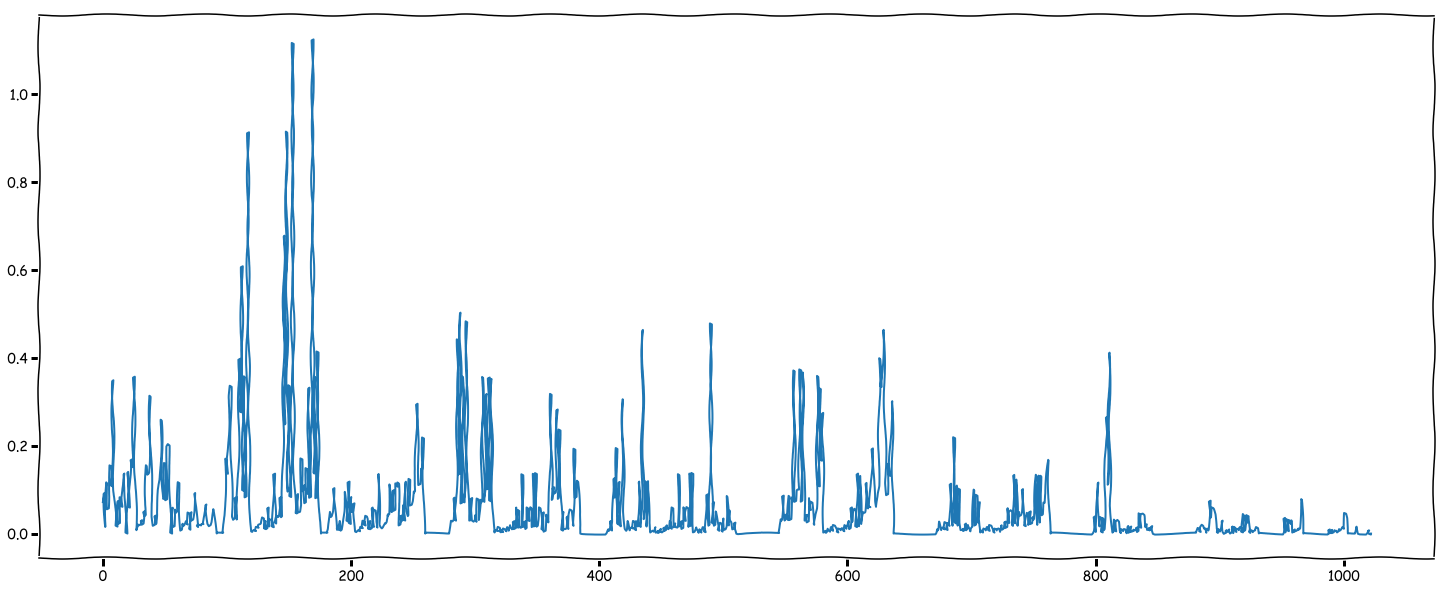

In [176]:
SCORE = pd.DataFrame()
for k in efs.get_metric_dict():
    score = efs.get_metric_dict()[k]['std_err']
    SCORE = SCORE.append([score])

SCORE.columns = ['std err']
SCORE.reset_index(drop=True, inplace=True)

plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(SCORE)

In [177]:
minSCORE = SCORE.loc[SCORE['std err'] == min(SCORE['std err'])]
minSCORE

,std err
180,0.000023


In [178]:
efs.subsets_[180]

{'feature_idx': (0, 1, 2, 8),
 'cv_scores': array([0.99987065, 0.99998137, 0.99983177, 0.99992318, 0.99996767,
        0.99996718, 0.99976813, 0.99994204, 0.99986685, 0.99998245]),
 'avg_score': 0.9999101293464042,
 'feature_names': ('X', 'X^2', 'X^3', 'X^9')}

In [173]:
features = efs.best_feature_names_
idx = efs.best_idx_

feat_list = pd.concat([pd.DataFrame([features]).T, pd.DataFrame([idx]).T], axis = 1)
feat_list.columns = ['Features', 'Index']
avg_score = pd.DataFrame()
for i in idx:
    avg_score = avg_score.append(pd.DataFrame([efs.subsets_[i]['avg_score']]))
avg_score.columns = ['Average Score']
avg_score.reset_index(drop=True,inplace=True)
feat_list = pd.concat([feat_list, avg_score], axis=1, ignore_index=True)
feat_list.columns = ['Features', 'Index', 'Average Score']
feat_list

,Features,Index,Average Score
0,X,0,0.573242
1,X^2,1,-0.116468
2,X^3,2,0.883008
3,X^9,8,0.058988


In [204]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_]*4)
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-2.628061,87.289744
1,X^2,37.113913,87.289744
2,X^3,55.792262,87.289744
3,X^9,0.000733,87.289744


In [355]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.813


**Therefore, the best equation through best subset selection is $Y$ = 87.289744 - 2.628061$X$ + 37.113913$X^2$ + 55.792262$X^3$ + 0.000733$X^9$ and the mean squared error is 0.813.**

### 8.c. Forward stepwise selection and backward stepwise selection

**Forward stepwise selection**

In [209]:
# import custom packages
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [279]:
lmf = LinearRegression()
sfs = SFS(lmf, k_features=(1,len(dfX.columns)), forward=True, floating=False, scoring='r2',cv=10).fit(dfX.values, dfY)

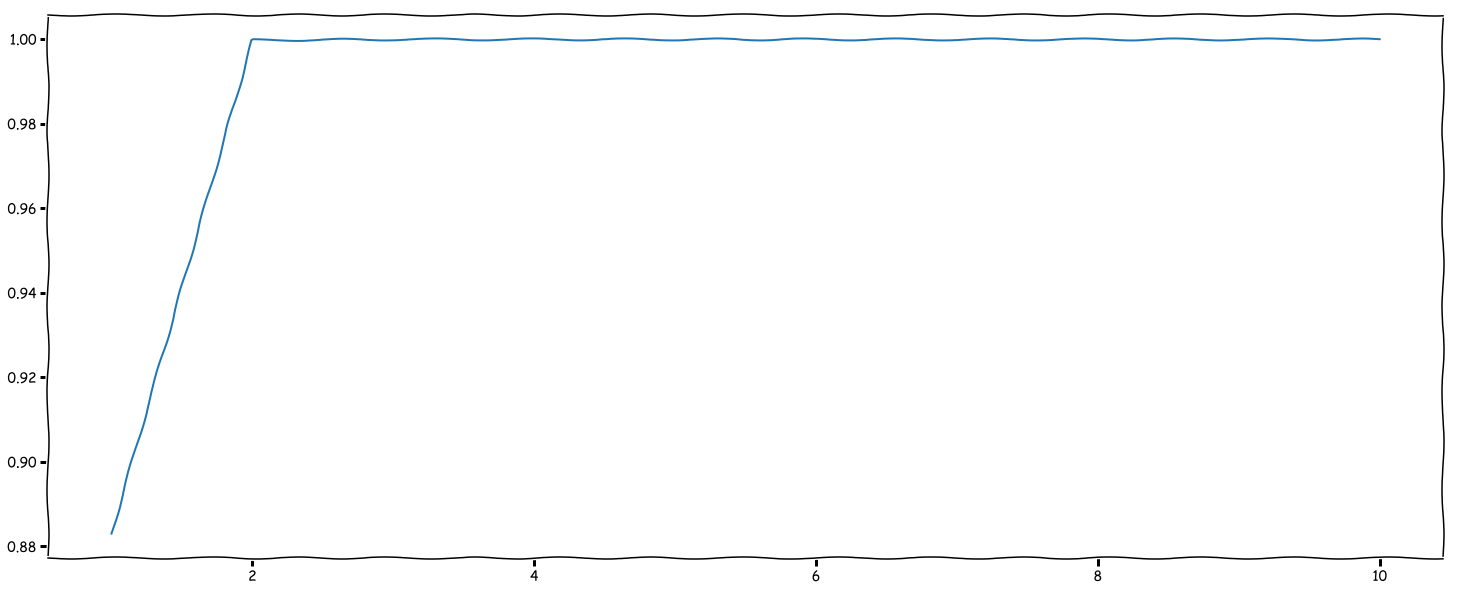

In [280]:
FSCORE = pd.DataFrame()
for k in sfs.get_metric_dict():
    fscore = sfs.get_metric_dict()[k]['avg_score']
    FSCORE = FSCORE.append([fscore])

FSCORE.columns = ['avg score']
FSCORE.reset_index(drop=True, inplace=True)
FSCORE.index = FSCORE.index+1

plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(FSCORE)

In [273]:
FSCORE

,avg score
1,0.883008
2,0.999724
3,0.999909
4,0.999910
5,0.999906
6,0.999905
7,0.999903
8,0.999898
9,0.999897
10,0.999889


**Forward stepwise regression has the higest $R^2$ for n=4.**

In [213]:
dfX.columns

Index(['X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10'], dtype='object')

In [255]:
feat = sfs.k_feature_idx_
feat

(0, 1, 2, 8)

In [215]:
feat_list = pd.DataFrame()
for i in feat:
    print(dfX.columns[i])
    feat_list = feat_list.append(pd.DataFrame([dfX.columns[i]]))
feat_list.reset_index(inplace=True, drop=True)
feat_list.columns = ['Features']
feat_list

X
X^2
X^3
X^9


,Features
0,X
1,X^2
2,X^3
3,X^9


*It's interesting to note that forward stepwise regression returns the same predictors as that of best subset selection based on $R^2$.*

In [263]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_]*4)
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-2.628061,87.289744
1,X^2,37.113913,87.289744
2,X^3,55.792262,87.289744
3,X^9,0.000733,87.289744


In [354]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.813


**Therefore, the best equation through forward stepwise selection is $Y$ = 87.289744 - 2.628061$X$ + 37.113913$X^2$ + 55.792262$X^3$ + 0.000733$X^9$ and the mean squared error is 0.813.**

**Backward stepwise selection**

In [278]:
lmb = LinearRegression()
sfs = SFS(lmb, k_features=(1,len(dfX.columns)), forward=False, floating=False, scoring='r2',cv=10).fit(dfX.values, dfY)

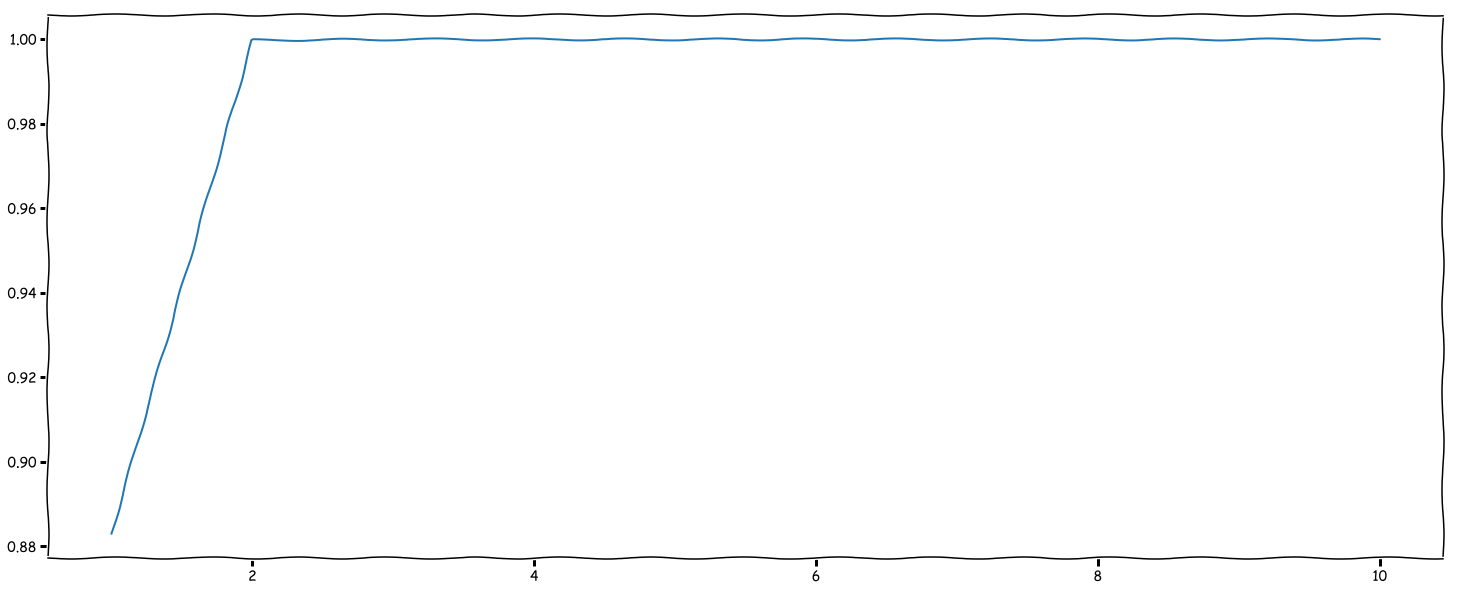

In [286]:
BSCORE = pd.DataFrame()
for k in sfs.get_metric_dict():
    bscore = sfs.get_metric_dict()[k]['avg_score']
    BSCORE = BSCORE.append([bscore])

BSCORE.columns = ['avg score']
BSCORE.reset_index(drop=True, inplace=True)
BSCORE.index = BSCORE.index+1

plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(BSCORE)

In [287]:
BSCORE

,avg score
1,0.883008
2,0.999724
3,0.999909
4,0.999910
5,0.999906
6,0.999905
7,0.999903
8,0.999898
9,0.999897
10,0.999889


**Forward stepwise regression has the higest $R^2$ for n=4.**

In [290]:
dfX.columns

Index(['X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10'], dtype='object')

In [291]:
feat = sfs.k_feature_idx_
feat

(0, 1, 2, 8)

In [292]:
feat_list = pd.DataFrame()
for i in feat:
    print(dfX.columns[i])
    feat_list = feat_list.append(pd.DataFrame([dfX.columns[i]]))
feat_list.reset_index(inplace=True, drop=True)
feat_list.columns = ['Features']
feat_list

X
X^2
X^3
X^9


,Features
0,X
1,X^2
2,X^3
3,X^9


*It's interesting to note that backward stepwise regression returns the same predictors as that of best subset selection  and forward stepwise selection based on $R^2$.*

In [293]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_]*4)
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-2.628061,87.289744
1,X^2,37.113913,87.289744
2,X^3,55.792262,87.289744
3,X^9,0.000733,87.289744


In [356]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.813


**Therefore, the best equation through backward stepwise selection is $Y$ = 87.289744 - 2.628061$X$ + 37.113913$X^2$ + 55.792262$X^3$ + 0.000733$X^9$ and the mean squared error is 0.813.**

### 8.d. Lasso regression

In [323]:
# import custom packages
from sklearn.linear_model import Lasso

In [324]:
# standardisation
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(dfX)
dfX_scaled = scaler.transform(dfX)

In [325]:
n = 100
lambdas = (np.logspace(10, -2, num=100))

In [326]:
coefs = []
MSE = []
for k in lambdas:
    lassomod = Lasso(alpha=k, fit_intercept=True).fit(dfX_scaled,dfY)
    coefs.append(lassomod.coef_)
    MSE.append(mean_squared_error(dfY, lassomod.predict(dfX_scaled)))

In [327]:
coefPD = pd.DataFrame(coefs)

In [328]:
coefPD.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
1,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
2,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
3,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0


In [329]:
coefPD.shape

(100, 10)

In [330]:
lassomod.intercept_

array([93.82857568])

In [331]:
coefPD = pd.concat([pd.DataFrame([lassomod.intercept_]*100), coefPD], axis=1)
coefPD.columns = ['Intercept', 'X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
coefPD.shape

(100, 11)

In [334]:
coefPD.head()

,Intercept,X,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
0,93.828576,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
1,93.828576,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
2,93.828576,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
3,93.828576,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,93.828576,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0


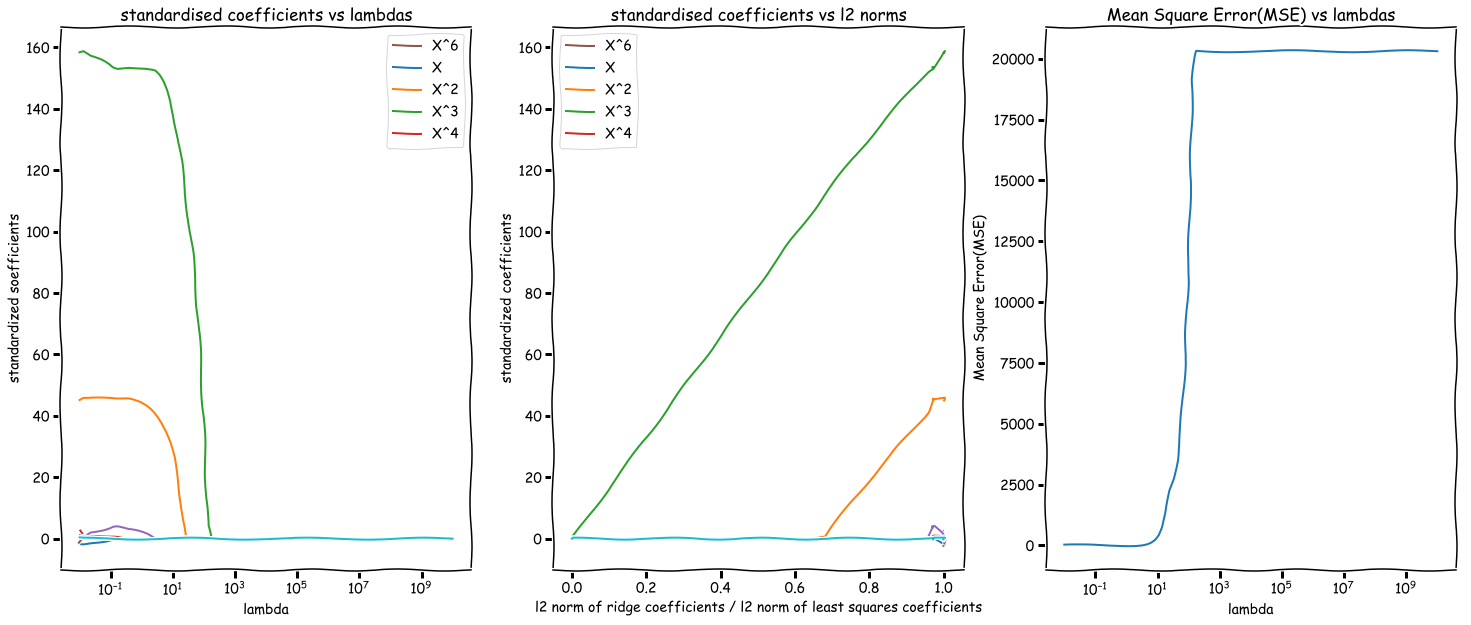

In [338]:
plt.xkcd()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10))

# indexing the five largest coefficients
idx = np.argpartition(np.abs(coefs[-1]), -5)[-5:]

# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('standardized soefficients')
ax1.set_title('standardised coefficients vs lambdas')
ax1.legend(np.array(ax1.get_lines())[idx], dfX.columns[idx])

# standardised coefficients vs l2 norms
l2norm = linalg.norm(coefs[-1])
l2coefs = linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], dfX.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');

In [339]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.5, random_state=42)

In [340]:
# standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [341]:
# MSE with only the intercept
lmMSEintercept = np.mean(pow((y_train.mean()-y_test), 2))
print("MSE with only the intercept: ", lmMSEintercept)

# MSE for lambda = 0; this is similar to least squares linear regression
lmlasso0 = Lasso(alpha=0, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict0 = lmlasso0.predict(X_test_scaled)
lmMSE0 = mean_squared_error(y_test, lmpredict0)
print("MSE at lambda = 0: ", lmMSE0)

# MSE for lambda = 1
lmridge1 = Lasso(alpha=1, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1 = lmridge1.predict(X_test_scaled)
lmMSE1 = mean_squared_error(y_test, lmpredict1)
print("MSE at lambda = 1: ", lmMSE1)

# MSE for lambda = 4
lmlasso4 = Lasso(alpha=4, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict4 = lmlasso4.predict(X_test_scaled)
lmMSE4 = mean_squared_error(y_test, lmpredict4)
print("MSE at lambda = 4: ", lmMSE4)

# MSE for lambda = pow(10, 10)
lmlasso1010 = Lasso(alpha=pow(10, 10), fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1010 = lmlasso1010.predict(X_test_scaled)
lmMSE1010 = mean_squared_error(y_test, lmpredict1010)
print("MSE at lambda = 10^10: ", lmMSE1010)

MSE with only the intercept:  Y    22383.910933
dtype: float64
MSE at lambda = 0:  2.145173136871151
MSE at lambda = 1:  5.89937217851773
MSE at lambda = 4:  55.053650542666645
MSE at lambda = 10^10:  22383.91093261232


In [342]:
# finding the best lambda using CV
from sklearn.linear_model import LassoCV
lmlassoCV = LassoCV(alphas=lambdas, cv=10).fit(X_train_scaled, y_train)
lmlassoCValpha = lmlassoCV.alpha_
print("Best lambda: ", lmlassoCValpha)

Best lambda:  0.01


In [359]:
# performing lasso regression using best lambda
lmlasso = Lasso(alpha=lmlassoCValpha, fit_intercept=True).fit(X_train_scaled, y_train)
lmlasso_MSE = mean_squared_error(y_test, lmlasso.predict(X_test_scaled))
print('MSE for best lambda: ', round(lmlasso_MSE, 3))

MSE for best lambda:  1.382


In [350]:
intercept_list = pd.DataFrame([lmlasso.intercept_]*10)
coef_list = pd.concat([intercept_list, pd.DataFrame([lmlasso.coef_]).T], axis = 1)
coef_list.reset_index(inplace=True, drop=True)
coef_list.columns = ['Intercept', 'Coefficients']
coef_list.index = coef_list.index+1
coef_list

,Intercept,Coefficients
1,100.10319,-1.621967
2,100.10319,41.587344
3,100.10319,144.624937
4,100.10319,2.440223
5,100.10319,1.442031
6,100.10319,-0.000000
7,100.10319,0.000000
8,100.10319,-1.194567
9,100.10319,0.000000
10,100.10319,-0.050617


**Therefore, the best equation through lasso regression is $Y$ = 100.10319 - 1.621967$X$ +  41.587344$X^2$ + 144.624937$X^3$ + 2.440223$X^4$ + 1.442031$X^5$ - 1.194567$X^8$ - 0.050617$X^{10}$ and the mean squared error is 1.382.**

### 8.f. Best subset selection and lasso regression for for $Y$ = $\beta_0$ + $\beta_7$$X^7$ + $\epsilon$

In [362]:
BETA7 = 23.457
Y7 = BETA0 + (BETA7*pow(X, 7)) + epsilon

**Best subset selection**

In [371]:
dfX7 = pd.DataFrame([pow(X, 7)]).T
dfX7.columns = ['X^7']
dfY7 = pd.DataFrame([Y7]).T
dfY7.columns = ['Y']

In [376]:
lm = LinearRegression()
efs = EFS(lm, min_features=1, max_features=1, scoring='r2', cv=10).fit(dfX7, dfY7)

Features: 1/1

In [385]:
SCORE = pd.DataFrame()
for k in efs.get_metric_dict():
    score = efs.get_metric_dict()[k]['std_err']
    SCORE = SCORE.append([score])

SCORE.columns = ['std err']
SCORE.reset_index(drop=True, inplace=True)

In [378]:
minSCORE = SCORE.loc[SCORE['std err'] == min(SCORE['std err'])]
minSCORE

,std err
0,0.000004


In [380]:
efs.subsets_[0]

{'feature_idx': (0,),
 'cv_scores': array([0.99997189, 0.9999999 , 0.99997896, 0.99999916, 0.99999854,
        0.99999936, 0.99999037, 0.99999957, 0.99996247, 0.99999969]),
 'avg_score': 0.9999899892896152,
 'feature_names': ('X^7',)}

In [381]:
features = efs.best_feature_names_
idx = efs.best_idx_

feat_list = pd.concat([pd.DataFrame([features]).T, pd.DataFrame([idx]).T], axis = 1)
feat_list.columns = ['Features', 'Index']
avg_score = pd.DataFrame()
for i in idx:
    avg_score = avg_score.append(pd.DataFrame([efs.subsets_[i]['avg_score']]))
avg_score.columns = ['Average Score']
avg_score.reset_index(drop=True,inplace=True)
feat_list = pd.concat([feat_list, avg_score], axis=1, ignore_index=True)
feat_list.columns = ['Features', 'Index', 'Average Score']
feat_list

,Features,Index,Average Score
0,X^7,0,0.99999


In [383]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_])
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X^7,2.128803,112.78394


In [384]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  5782.033


**Therefore, the best equation through best subset selection is $Y$ = 2.128803 + 112.78394$X^7$ and the mean squared error is 5782.033.**

**Lasso regression**

In [395]:
# standardisation
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(dfX7)
dfX7_scaled = scaler.transform(dfX7)

In [396]:
n = 100
lambdas = (np.logspace(10, -2, num=100))

In [397]:
coefs = []
MSE = []
for k in lambdas:
    lassomod = Lasso(alpha=k, fit_intercept=True).fit(dfX7_scaled,dfY7)
    coefs.append(lassomod.coef_)
    MSE.append(mean_squared_error(dfY7, lassomod.predict(dfX7_scaled)))

In [398]:
coefPD = pd.DataFrame(coefs)

In [399]:
coefPD.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [400]:
coefPD.shape

(100, 1)

In [401]:
lassomod.intercept_

array([-121.62519592])

In [402]:
coefPD = pd.concat([pd.DataFrame([lassomod.intercept_]*100), coefPD], axis=1)
coefPD.columns = ['Intercept', 'X^7']
coefPD.shape

(100, 2)

In [403]:
coefPD.head()

,Intercept,X^7
0,-121.625196,0.0
1,-121.625196,0.0
2,-121.625196,0.0
3,-121.625196,0.0
4,-121.625196,0.0


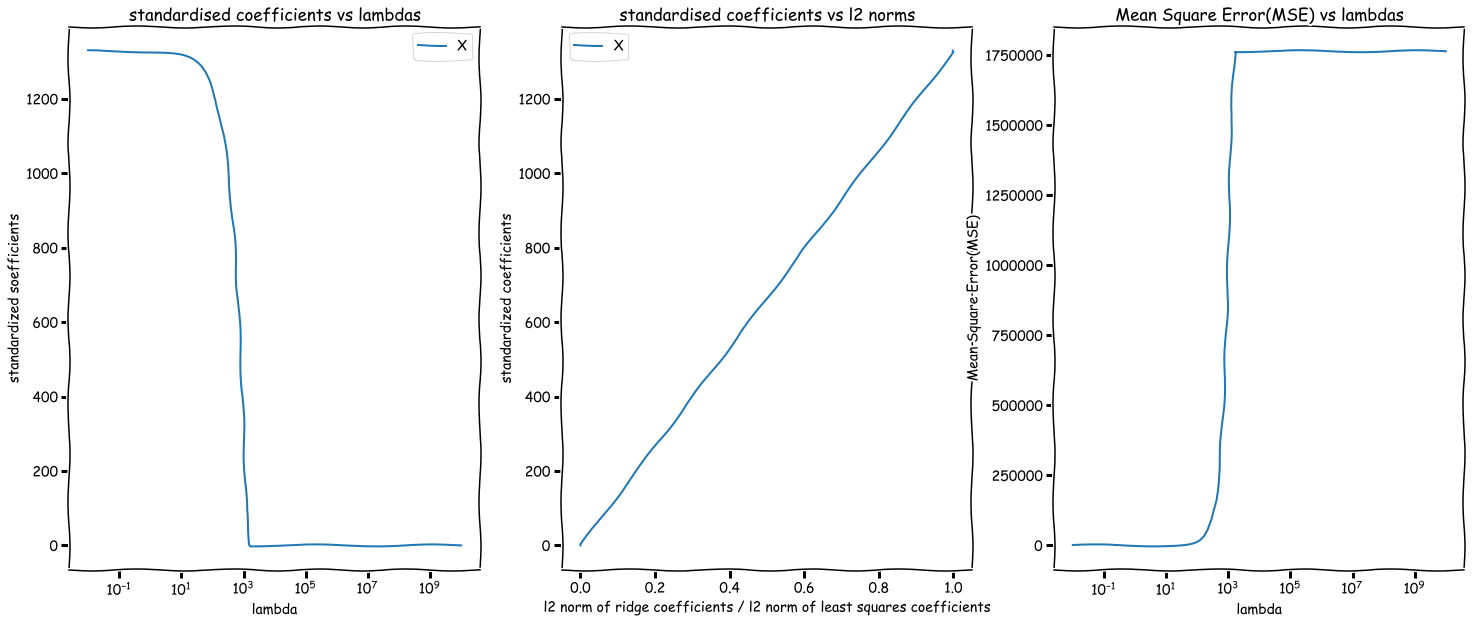

In [406]:
plt.xkcd()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10))

# indexing the only coefficient
idx = np.argpartition(np.abs(coefs[-1]), -1)[-1:]

# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('standardized soefficients')
ax1.set_title('standardised coefficients vs lambdas')
ax1.legend(np.array(ax1.get_lines())[idx], dfX.columns[idx])

# standardised coefficients vs l2 norms
l2norm = linalg.norm(coefs[-1])
l2coefs = linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], dfX.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');

In [407]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX7, dfY7, test_size=0.5, random_state=42)

In [408]:
# standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [409]:
# MSE with only the intercept
lmMSEintercept = np.mean(pow((y_train.mean()-y_test), 2))
print("MSE with only the intercept: ", lmMSEintercept)

# MSE for lambda = 0; this is similar to least squares linear regression
lmlasso0 = Lasso(alpha=0, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict0 = lmlasso0.predict(X_test_scaled)
lmMSE0 = mean_squared_error(y_test, lmpredict0)
print("MSE at lambda = 0: ", lmMSE0)

# MSE for lambda = 1
lmridge1 = Lasso(alpha=1, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1 = lmridge1.predict(X_test_scaled)
lmMSE1 = mean_squared_error(y_test, lmpredict1)
print("MSE at lambda = 1: ", lmMSE1)

# MSE for lambda = 4
lmlasso4 = Lasso(alpha=4, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict4 = lmlasso4.predict(X_test_scaled)
lmMSE4 = mean_squared_error(y_test, lmpredict4)
print("MSE at lambda = 4: ", lmMSE4)

# MSE for lambda = pow(10, 10)
lmlasso1010 = Lasso(alpha=pow(10, 10), fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1010 = lmlasso1010.predict(X_test_scaled)
lmMSE1010 = mean_squared_error(y_test, lmpredict1010)
print("MSE at lambda = 10^10: ", lmMSE1010)

MSE with only the intercept:  Y    1.476373e+06
dtype: float64
MSE at lambda = 0:  0.8589604665869818
MSE at lambda = 1:  1.5556607684273838
MSE at lambda = 4:  12.261925917822905
MSE at lambda = 10^10:  1476373.4230404827


In [410]:
# finding the best lambda using CV
from sklearn.linear_model import LassoCV
lmlassoCV = LassoCV(alphas=lambdas, cv=10).fit(X_train_scaled, y_train)
lmlassoCValpha = lmlassoCV.alpha_
print("Best lambda: ", lmlassoCValpha)

Best lambda:  0.01


In [411]:
# performing lasso regression using best lambda
lmlasso = Lasso(alpha=lmlassoCValpha, fit_intercept=True).fit(X_train_scaled, y_train)
lmlasso_MSE = mean_squared_error(y_test, lmlasso.predict(X_test_scaled))
print('MSE for best lambda: ', round(lmlasso_MSE, 3))

MSE for best lambda:  0.859


In [413]:
intercept_list = pd.DataFrame([lmlasso.intercept_])
coef_list = pd.concat([intercept_list, pd.DataFrame([lmlasso.coef_]).T], axis = 1)
coef_list.reset_index(inplace=True, drop=True)
coef_list.columns = ['Intercept', 'Coefficients']
coef_list.index = coef_list.index+1
coef_list

,Intercept,Coefficients
1,-72.609319,1433.946961


**Therefore, the best equation through lasso regression is $Y$ = -72.609319 + 1433.946961$X^7$ and the mean squared error is 0.859.**

**This suggests that when p<<n, then lasso provides a better fit (even if the intercept is quite off from its true value)
than best subset selection as suggested by the lower MSE through lasso regression. But, as p  increases to the point of
p$\approx$n, then best subset selection is more preferred, albeit it comes at a cost of greater computational requirement.**